In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from random import shuffle
import random
import os

In [ ]:
path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/'
def get_subpath():
  return 'train'

IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200

IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [ ]:
directories = ['train']


all_files = os.listdir(path + directories[0])
all_files.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(230)
random.shuffle(all_files) # shuffles the ordering of filenames (deterministic given the chosen seed)
split_1 = int(0.8 * len(all_files))
files = all_files[:split_1]
test_files = all_files[split_1:]

def get_categories(files):
  categories = []
  for img in files:

      fileName = img.split('.')[0]
      
      if 'Normal' in fileName: categories.append(0)
      elif 'COVID' in fileName: categories.append(1)
      elif 'Viral Pneumonia': categories.append(2)
  return categories

df = pd.DataFrame({
    'filename': files,
    'category': get_categories(files)
})

'Total size of the dataset: ', len(df)

('Total size of the dataset: ', 12122)

In [ ]:
df.head()

,filename,category
0,Normal-6783.png,0
1,Normal-3919.png,0
2,COVID-2422.png,1
3,Normal-5992.png,0
4,COVID-2862.png,1


In [ ]:
df.tail()

,filename,category
12117,Normal-38.png,0
12118,Normal-4747.png,0
12119,Normal-3671.png,0
12120,Normal-2245.png,0
12121,Normal-294.png,0


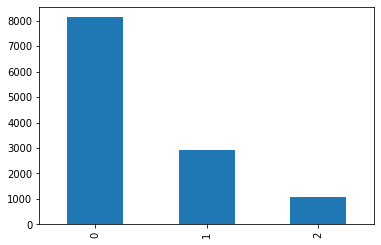

In [ ]:
'''
0 Represents Normal 
1 Represents COVID-19
2 Represents Viral Pneumonia 
'''
df['category'].value_counts().plot.bar()

In [ ]:
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'}) 

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df

,filename,category
0,Viral Pneumonia-969.png,Viral Pneumonia
1,Normal-1965.png,Normal
2,Normal-9099.png,Normal
3,Normal-7734.png,Normal
4,Normal-5951.png,Normal
...,...,...
12117,Normal-3347.png,Normal
12118,Normal-9146.png,Normal
12119,Normal-6633.png,Normal
12120,COVID-622.png,COVID-19


In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=170204050)
#train_df = train_df.reset_index(drop=True)
#validate_df = validate_df.reset_index(drop=True)

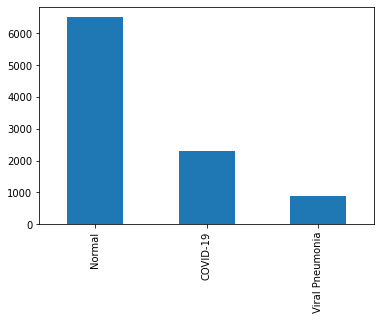

In [ ]:
train_df['category'].value_counts().plot.bar()

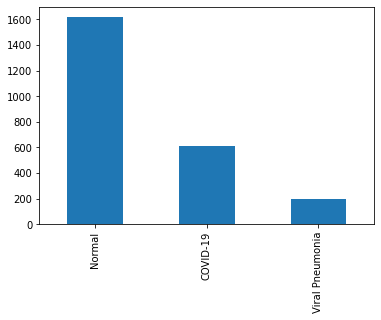

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 5

In [ ]:
def train_datagen_creator():
  return ImageDataGenerator (
      
      rotation_range = 15,
      rescale = 1./255,
      
      shear_range = 0.1,
      zoom_range = 0.2,
      
      horizontal_flip = True,
      width_shift_range = 0.1,
      height_shift_range = 0.1
  )

train_datagen = train_datagen_creator()

def get_train_generator():
  return train_datagen.flow_from_dataframe (
      
      train_df, 
      path + get_subpath(), 
      x_col = 'filename',
      y_col = 'category',
      target_size = IMAGE_SIZE,
      class_mode = 'categorical',
      batch_size = batch_size
  )
train_generator = get_train_generator()

Found 9697 validated image filenames belonging to 3 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

def get_validation_generator():
  return validation_datagen.flow_from_dataframe (
      
      validate_df, 
      path + get_subpath(), 
      x_col ='filename',
      y_col = 'category',
      target_size = IMAGE_SIZE,
      class_mode = 'categorical',
      batch_size = batch_size
  )
validation_generator = get_validation_generator()

Found 2425 validated image filenames belonging to 3 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

def createModel():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax', name='predictions')) 

  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  model.summary()
  return model
  
model = createModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 97, 97, 64)       2

# Callbacks

## Early Stop

To prevent overfitting, we will stop the learning after 10 epochs and if the val_loss value has not decreased

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
def earlyStopping(patience=10):
  return EarlyStopping(patience=patience)
earlystop = earlyStopping()

# Learning Rate Reduction

We will reduce the learning rate when then accuracy does not increase for 2 steps

In [ ]:

def lr_reduction():
  return ReduceLROnPlateau(monitor = 'val_accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.00001)
learning_rate_reduction = lr_reduction()
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
epochs = 25

history = model.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/25
1939/1939 [==============================] - 378s 194ms/step - loss: 0.8803 - accuracy: 0.6457 - val_loss: 0.6843 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 2/25
1939/1939 [==============================] - 181s 93ms/step - loss: 0.7205 - accuracy: 0.6948 - val_loss: 0.5890 - val_accuracy: 0.7225 - lr: 0.0010
Epoch 3/25
1939/1939 [==============================] - 182s 94ms/step - loss: 0.7005 - accuracy: 0.7077 - val_loss: 0.9482 - val_accuracy: 0.5901 - lr: 0.0010
Epoch 4/25
1939/1939 [==============================] - 185s 96ms/step - loss: 0.6574 - accuracy: 0.7270 - val_loss: 0.8176 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 5/25
1939/1939 [==============================] - 181s 93ms/step - loss: 0.6221 - accuracy: 0.7441 - val_loss: 0.5153 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 6/25
1939/1939 [==============================] - 181s 93ms/step - loss: 0.5966 - accuracy: 0.7543 - val_loss: 0.5666 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 7/25
1939/1939 [=================

In [ ]:
model.save_weights("COVID-Model-250-{}-{}-{}-{}-1.h5".format(IMAGE_WIDTH, 3, batch_size, epochs))

# Visualize Training Performance 

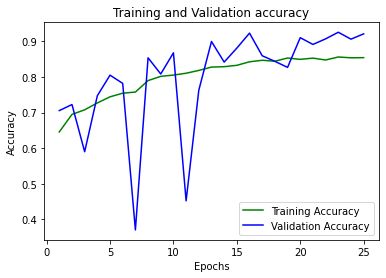

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
numEpochs = range(1,  epochs + 1)
plt.plot(numEpochs, accuracy, 'g', label='Training Accuracy')
plt.plot(numEpochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

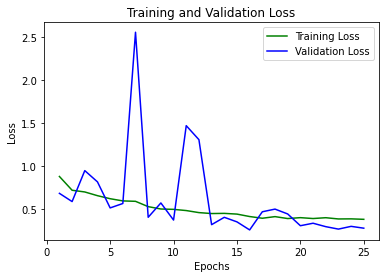

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  epochs + 1)
plt.plot(numEpochs, loss, 'g', label='Training Loss')
plt.plot(numEpochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prepare Testing Data

In [ ]:
test_df = pd.DataFrame({
    'filename': test_files
})

nb_samples = test_df.shape[0]

In [ ]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename
0,COVID-2408.png
1,Normal-6052.png
2,Normal-5826.png
3,Normal-8584.png
4,Normal-3463.png
...,...
3026,Normal-54.png
3027,Normal-7637.png
3028,Normal-207.png
3029,Normal-7935.png


# Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    
    test_df, 
    path + get_subpath(), 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 3031 validated image filenames.


# Form Predictions

In [ ]:
predict = model.predict(test_generator, steps = np.ceil(nb_samples/batch_size))

## Pick the category that has the highest probability 

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df

,filename,category
0,COVID-2408.png,COVID-19
1,Normal-6052.png,Normal
2,Normal-5826.png,Normal
3,Normal-8584.png,Normal
4,Normal-3463.png,Normal
...,...,...
3026,Normal-54.png,Normal
3027,Normal-7637.png,Normal
3028,Normal-207.png,Normal
3029,Normal-7935.png,Normal


In [ ]:
test_df['category'] = test_df['category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

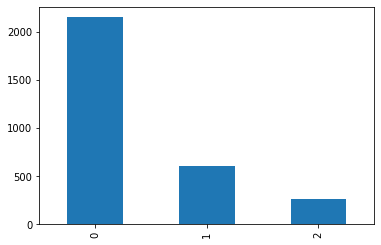

In [ ]:
test_df['category'].value_counts().plot.bar()

# Predicted result with images

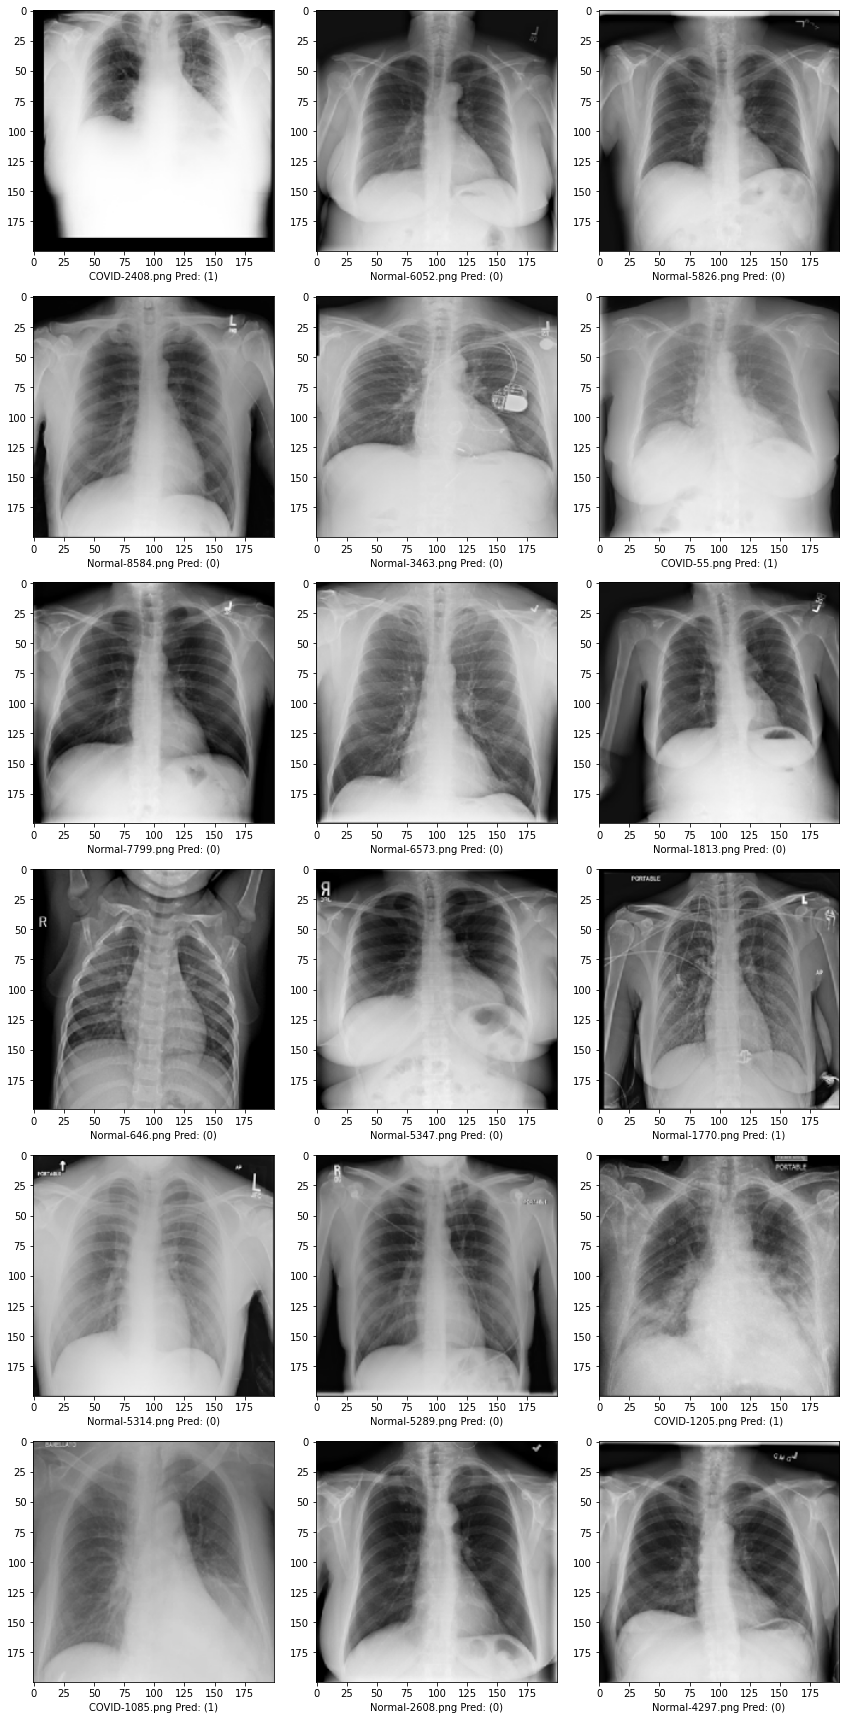

In [ ]:
sample_test = test_df.head(18)
sample_test.head()

plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    category = row['category']
    
    img = load_img(path + get_subpath() + '/' + filename, target_size=IMAGE_SIZE)
    
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' Pred: (' + "{}".format(category) + ')' )
    
plt.tight_layout()
plt.show()

# Calculate Model Accuracy

In [ ]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['category']
    
    img = load_img(path + get_subpath() + '/' + filename, target_size=IMAGE_SIZE)
    if 'Normal' in filename:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in filename:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in filename:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [ ]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 92.41%
Correct Predictions: 2801 Total Predictions: 3031

Normal Predictions: 2006 Accuracy 97.19%
COVID-19 Predictions: 562 Accuracy 78.82%
Viral Pneumonia Predictions: 233 Accuracy 91.73%


In [ ]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    
    if 'Normal' in filename: actual.append(0)
    if 'COVID' in filename: actual.append(1)
    if 'Viral Pneumonia' in filename: actual.append(2)
        
    pred.append(row[1][1])

In [ ]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2064
           1       0.92      0.79      0.85       713
           2       0.87      0.92      0.89       254

    accuracy                           0.92      3031
   macro avg       0.91      0.89      0.90      3031
weighted avg       0.92      0.92      0.92      3031



In [ ]:
confusion_matrix(actual, pred)

array([[2006,   43,   15],
       [ 130,  562,   21],
       [  18,    3,  233]])

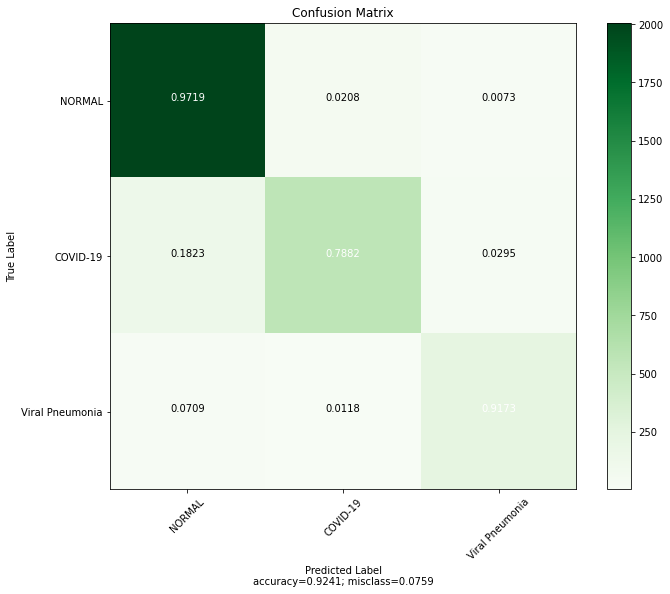

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools
    
cf = confusion_matrix(actual, pred)

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
target_names = ['NORMAL','COVID-19', 'Viral Pneumonia']

plot_confusion_matrix(cf, target_names)

# Cross Validation


In [ ]:
def getModelAccuracy(dataframe):
    sample_test = dataframe
    correctPredictions = 0

    correctNormalPred = 0
    correctCovidPred = 0
    correctPneuPred = 0

    totalNormalPred = 0
    totalCovidPred = 0
    totalPneuPred = 0

    for index, row in sample_test.iterrows():

        filename = row['filename']
        prediction = row['category']

        img = load_img(path + get_subpath() + '/' + filename, target_size=IMAGE_SIZE)

        if 'Normal' in filename:

            if prediction == 0:
                correctPredictions += 1
                correctNormalPred += 1

            totalNormalPred += 1

        if 'COVID' in filename:

            if prediction == 1: 
                correctPredictions += 1
                correctCovidPred += 1

            totalCovidPred += 1

        if 'Viral Pneumonia' in filename:

            if prediction == 2: 
                correctPredictions += 1
                correctPneuPred += 1

            totalPneuPred += 1
            
    print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
    print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

    print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
    print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
    print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))
    
    return (correctPredictions / test_df.shape[0]) * 100

In [ ]:
from sklearn.model_selection import KFold
inputs = np.concatenate((df['filename'], test_df['filename']), axis=0)
targets = np.concatenate((df['category'], test_df['category']), axis=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 198, 198, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 99, 99, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 97, 97, 64)      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


                    filename  category
0    Viral Pneumonia-969.png         2
1            Normal-5951.png         0
2            Normal-7006.png         0
3            Normal-5510.png         0
4            Normal-2437.png         0
5            Normal-5904.png         0
6            Normal-1245.png         0
7             COVID-1322.png         1
8    Viral Pneumonia-568.png         2
9            Normal-6378.png         0
10   Viral Pneumonia-923.png         0
11           Normal-6851.png         0
12   Viral Pneumonia-802.png         2
13  Viral Pneumonia-1041.png         2
14            COVID-1534.png         1
15           Normal-7263.png         0
16           Normal-2589.png         0
17           Normal-6206.png         0
18            Normal-279.png         1
19           Normal-3094.png         0
20             COVID-658.png         0
21            Normal-664.png         0
22            COVID-3429.png         1
23           Normal-4417.png         0
24            Normal-985.

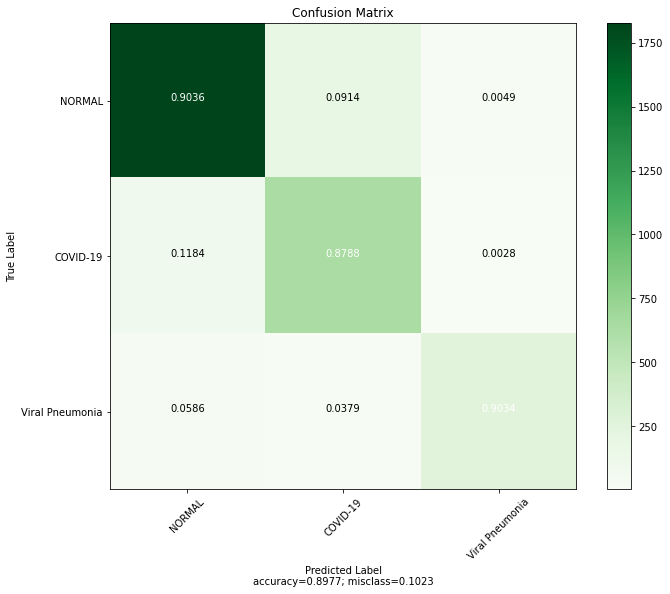

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_18 (Bat  (None, 198, 198, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 99, 99, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_19 (Bat  (None, 97, 97, 64)      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


                    filename  category
0    Viral Pneumonia-806.png         2
1   Viral Pneumonia-1259.png         1
2             COVID-2751.png         0
3            Normal-7848.png         0
4            Normal-6307.png         0
5            Normal-1297.png         0
6            Normal-5749.png         0
7            Normal-5630.png         0
8             Normal-700.png         0
9            Normal-1292.png         2
10            COVID-1764.png         1
11           Normal-2740.png         0
12   Viral Pneumonia-745.png         2
13           Normal-3320.png         0
14           Normal-5990.png         0
15           Normal-2088.png         0
16            COVID-1404.png         0
17             COVID-170.png         0
18            Normal-695.png         0
19           Normal-6999.png         0
20           Normal-9586.png         0
21           Normal-1461.png         0
22            COVID-1762.png         1
23              COVID-77.png         1
24           Normal-9363.

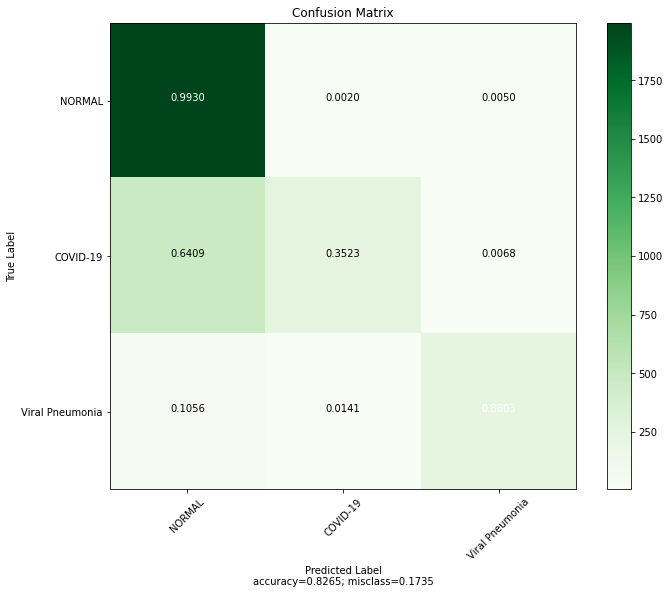

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_24 (Bat  (None, 198, 198, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 99, 99, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_25 (Bat  (None, 97, 97, 64)      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


                    filename  category
0            Normal-1965.png         0
1            Normal-9184.png         0
2            Normal-4481.png         0
3            Normal-2325.png         0
4            Normal-6299.png         0
5            Normal-1354.png         0
6            Normal-8303.png         0
7             Normal-796.png         0
8            Normal-9060.png         0
9              COVID-544.png         1
10           Normal-7458.png         0
11           Normal-6812.png         0
12  Viral Pneumonia-1230.png         2
13           Normal-7247.png         0
14   Viral Pneumonia-915.png         2
15             COVID-438.png         1
16           Normal-1572.png         1
17           Normal-7402.png         0
18           Normal-8769.png         0
19           Normal-4721.png         0
20           Normal-9234.png         0
21           Normal-7111.png         0
22   Viral Pneumonia-178.png         2
23           Normal-8413.png         0
24           Normal-2369.

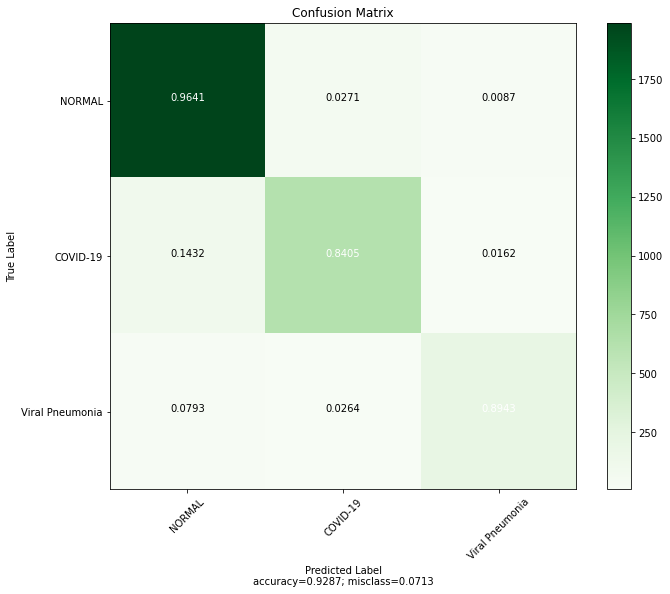

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_30 (Bat  (None, 198, 198, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 99, 99, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_31 (Bat  (None, 97, 97, 64)      

In [ ]:
fold_no = 1
batch_size = 5
epochs = 25

acc_per_fold = []
perf_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

for train, test in kfold.split(inputs, targets):
    
    model = createModel()
    

    cross_val_df = pd.DataFrame ({
        'filename': inputs[train],
        'category': get_categories(inputs[train])
    })
    
    cross_val_df["category"] = cross_val_df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'})
    
    train_df, validate_df = train_test_split(cross_val_df, test_size=0.20)
    train_df = train_df.reset_index(drop=True)
    validate_df = validate_df.reset_index(drop=True)
    
    ##Callbacks 
    callbacks = [earlyStopping(), lr_reduction()]
    

    train_generator = get_train_generator()
    
    validation_generator = get_validation_generator()

    
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    
    history = model.fit(
      train_generator, 
      epochs = epochs,
      validation_data = validation_generator,
      validation_steps = total_validate//batch_size,
      steps_per_epoch = total_train//batch_size,
      callbacks = callbacks   
    )
    
    
    ##Separate Testing Data 
    test_filenames = []
    
    for img in inputs[test]:
        test_filenames.append(img)
        
    test_df = pd.DataFrame({
        'filename': test_filenames
    })
    
    nb_samples = test_df.shape[0]
    
    test_gen = ImageDataGenerator(rescale = 1./255)
    test_generator = test_gen.flow_from_dataframe(
        test_df, 
        path + get_subpath(), 
        x_col = 'filename',
        y_col = None,
        class_mode = None,
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        shuffle = False
    )
        
    #Get Test Data Predictions 
    predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))
    
    test_df['category'] = np.argmax(predict, axis=-1)
    label_map = dict((v,k) for k,v in train_generator.class_indices.items())
    test_df['category'] = test_df['category'].replace(label_map)
    test_df['category'] = test_df['category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

    
    actual = []
    pred = []

    for row in test_df.iterrows():

        filename = row[1][0]

        if 'Normal' in filename: actual.append(0)
        if 'COVID' in filename: actual.append(1)
        if 'Viral Pneumonia' in filename: actual.append(2)

        pred.append(row[1][1])
    
    print(test_df[0:30])
    print(classification_report(actual, pred))
    print(confusion_matrix(actual, pred))
    
    
    # Increase fold number
    fold_no = fold_no + 1

    
    # Get performance metrics
    
    accuracy = getModelAccuracy(test_df)
    acc_per_fold.append(accuracy)
    perf_per_fold.append([actual, pred])
    cf = confusion_matrix(actual, pred)
    
    target_names = ['NORMAL','COVID-19', 'Viral Pneumonia']
    plot_confusion_matrix(cf, target_names)
    

print(acc_per_fold)
print(perf_per_fold)

In [ ]:
model.save_weights("COVID-Model-Cross-Validation-Full-{}-{}-{}-{}-1.h5".format(IMAGE_WIDTH, 3, batch_size, epochs))

In [ ]:
accuracy_cross = history.history['accuracy']
val_accuracy_cross = history.history['val_accuracy']
numEpochs = range(1,  epochs + 1)
plt.plot(numEpochs, accuracy_cross, 'g', label='Training Accuracy')
plt.plot(numEpochs, val_accuracy_cross, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('CrossValidatedModel.h5')